# Exploring Hamburg Neighbourhoods and their Restaurant preferences

## Problem description

The pizza service "Fast Pizza" is successfully operating in the neighbourhood of Eimsbüttel in Hamburg, Germany. They would like to expand and open up a new branch in a different neighbourhood. The objective of the project is to find a neighbourhood in Hamburg that is similar to Eimsbüttel in terms of demographics and food preferences.
The target audience is the owner of "Fast Pizza". The analysis could also be useful for any other restaurant owner wishing to expand in Hamburg.

## Preparation work

#### Import libraries

In [3]:
#!conda install -c conda-forge folium=0.5.0 --yes

In [94]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim 
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from bs4 import BeautifulSoup
import requests

#### Links to data sources

In [95]:
# Demographic data for Hamburg neighbourhoods
demographics_url="https://www.statistik-nord.de/fileadmin/Dokumente/Datenbanken_und_Karten/Stadtteilprofile/StadtteilprofileBerichtsjahr2017.xlsx"

# Locations of Hamburg Neighbourhoods
locations_url="https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs"

## Locations of Neighbourhoods

#### Web scraping from wikipedia

In [96]:
page_link = locations_url
page_response = requests.get(page_link, timeout=5)
soup=BeautifulSoup(page_response.content.decode('utf-8', 'ignore'), 'lxml')

In [97]:
tables = soup.find_all('table', class_='wikitable sortable')

# find tble containing neighbourhoods:
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[0] == ['Stadtteil']:
        break
        
#print(table.prettify())

In [98]:
# Scrap column names
column_names=[]
table_header=table.find_all('th')
for th in table_header:
    column_names.append(th.get_text()) 
map(lambda x: str.replace(x, r'\s+|\\n', ' ', regex=True), column_names)
column_names

['Stadtteil\n',
 'Ortsteile\n',
 'Bezirk\n',
 'Fläche(km²)\n',
 'Einwohner\n',
 'Bevölkerungsdichte(Einwohner/km²)\n',
 'Koordinaten\n',
 'Karte\n']

In [222]:
# Translate column names and define data frame
column_names=['neighbourhood', 'quarter', 'borough', 'area', 'inhabitants', 'population density','coordinates', 'map']

# Determine number of rows
nrows=0
for tr in table.find_all('tr'):
    column=tr.find_all('td')
    if len(column)>0:
        nrows+=1

df = pd.DataFrame(columns=column_names,index=range(0,nrows))

row_marker=0
for tr in table.find_all('tr'):
    column_marker=0
    column=tr.find_all('td')
    for td in column:
        df.iat[row_marker, column_marker]=td.get_text() 
        column_marker +=1
    if len(column)>0:
        row_marker +=1

df.replace(r'\s+|\\n', ' ', regex=True, inplace=True)
df.head()

,neighbourhood,quarter,borough,area,inhabitants,population density,coordinates,map
0,Hamburg-Altstadt!Hamburg-Altstadt,101!101–102,Hamburg-Mitte,"02,4!2,4",2305,960,"53° 33′ 0″ N, 10° 0′ 0″ O",
1,HafenCity!HafenCity,103!103–104,Hamburg-Mitte,"02,2!2,2",3627,1649,"53° 32′ 28″ N, 10° 0′ 1″ O",
2,Neustadt!Neustadt,105!105–108,Hamburg-Mitte,"02,3!2,3",12.719,5530,"53° 33′ 7″ N, 9° 59′ 8″ O",
3,St.Pauli!St. Pauli,109!109–112,Hamburg-Mitte,"02,5!2,5",22.501,9000,"53° 33′ 25″ N, 9° 57′ 50″ O",
4,St.Georg!St. Georg,113!113–114,Hamburg-Mitte,"02,4!2,4",11.055,4606,"53° 33′ 18″ N, 10° 0′ 44″ O",


In [223]:
# clean up data frame
Neighbourhood= df["neighbourhood"].str.split("!", n = 1, expand = True) 
Coordinates= df["coordinates"].str.split(",", n = 1, expand = True) 

# making separate first name column from new data frame 
df["neighbourhood"]= Neighbourhood[1].map(lambda x: str(x)[:-1])
df["latitude"]= Coordinates[0] 
df["longitude"]= Coordinates[1] 
df.drop(columns =["quarter", "area", "inhabitants", "population density", "coordinates", "map"], inplace = True) 
df.head()

,neighbourhood,borough,latitude,longitude
0,Hamburg-Altstadt,Hamburg-Mitte,53° 33′ 0″ N,10° 0′ 0″ O
1,HafenCity,Hamburg-Mitte,53° 32′ 28″ N,10° 0′ 1″ O
2,Neustadt,Hamburg-Mitte,53° 33′ 7″ N,9° 59′ 8″ O
3,St. Pauli,Hamburg-Mitte,53° 33′ 25″ N,9° 57′ 50″ O
4,St. Georg,Hamburg-Mitte,53° 33′ 18″ N,10° 0′ 44″ O


In [224]:
# Convert format for coordiantes
Lat=df["latitude"].str.replace(u'° ','.').str.replace('′ ','.').str.replace('″',' ').str.replace('N','')
Lat=Lat.str.split('.', n = 2, expand = True)
Lat[0]=pd.to_numeric(Lat[0])
Lat[1]=pd.to_numeric(Lat[1])/60.0
Lat[2]=pd.to_numeric(Lat[2])/3600.0
Lat=Lat[0]+Lat[1]+Lat[2]

Long=df["longitude"].str.replace(u'° ','.').str.replace('′ ','.').str.replace('″','').str.replace('O','')
Long=Long.str.split('.', n = 2, expand = True)
Long[0]=pd.to_numeric(Long[0])
Long[1]=pd.to_numeric(Long[1])/60.0
Long[2]=pd.to_numeric(Long[2])/3600.0
Long=Long[0]+Long[1]+Long[2]

df["latitude"]=Lat
df["longitude"]=Long
df.head()

,neighbourhood,borough,latitude,longitude
0,Hamburg-Altstadt,Hamburg-Mitte,53.550000,10.000000
1,HafenCity,Hamburg-Mitte,53.541111,10.000278
2,Neustadt,Hamburg-Mitte,53.551944,9.985556
3,St. Pauli,Hamburg-Mitte,53.556944,9.963889
4,St. Georg,Hamburg-Mitte,53.555000,10.012222


## Demographics Dataset

### Read data and pre process dataset

In [225]:
# Read Demogrpahics data
xlsx_d=pd.ExcelFile(demographics_url)

In [226]:
# Transform into data frame and print headers
df_d = xlsx_d.parse('Stadtteilprofile 2017', skiprows=3, index_col=None, na_values=['NA'])
list(df_d.columns.values)

['Unnamed: 0',
 'Anzahl der Einwohnerinnen und Einwohner',
 'Anzahl der Kinder und Jugendlichen unter 18 Jahren',
 'Anteil Kinder und Jugendlicher unter 18 Jahren an der Gesamt-bevölkerung',
 'Anzahl älterer Einwohnerinnen und Einwohner über 64 Jahren',
 'Anteil älterer Einwohnerinnen und Einwohner über 64 Jahren an der Gesamt-bevölkerung',
 'Anzahl ausländischer Einwohnerinnen und Einwohner ',
 'Anteil ausländischer Einwohnerinnen und Einwohner an der Gesamt-bevölkerung',
 'Anzahl der Einwohnerinnen und Einwohner mit Migrations-hintergrund',
 'Anteil der Einwohnerinnen und Einwohner mit Migrations-hintergrund an der Gesamt-bevölkerung',
 'Anzahl der Kinder und Jugendlichen unter 18 Jahren mit Migrations-hintergrund',
 'Anteil Kinder und Jugendlicher unter 18 Jahren mit Migrations-hintergrund an allen Kindern und Jugendlichen unter 18 Jahren',
 'Anzahl der Haushalte',
 'Durchschnittliche Anzahl der Personen je Haushalt',
 'Anzahl der Einpersonen-haushalte',
 'Anteil der Haushalte, in d

In [227]:
# Drop some columns
df_data= df_d.drop(['Anzahl der Kinder und Jugendlichen unter 18 Jahren',
 'Anzahl älterer Einwohnerinnen und Einwohner über 64 Jahren',
 'Anzahl ausländischer Einwohnerinnen und Einwohner ',
 'Anzahl der Einwohnerinnen und Einwohner mit Migrations-hintergrund',
 'Anzahl der Kinder und Jugendlichen unter 18 Jahren mit Migrations-hintergrund',
 'Anteil Kinder und Jugendlicher unter 18 Jahren mit Migrations-hintergrund an allen Kindern und Jugendlichen unter 18 Jahren',
 'Anzahl der Haushalte',
 'Anzahl der Einpersonen-haushalte',
 'Anzahl der Haushalte mit Kindern',
 'Anteil der Haushalte, in denen Kinder leben, an allen Haushalten',
 'Anzahl der Haushalte, in denen Alleinerziehende leben',
 'Fläche in km²',
 'Anzahl der Lebendgeborenen',
 'Anzahl der Sterbefälle',
 'Zuzüge über die Stadtteilgrenze im Jahr 2017',
 'Fortzüge über die Stadtteilgrenze im Jahr 2017',
 'Sozial-versicherungs-pflichtig Beschäftigte am Wohnort',
 'Anzahl der Arbeitslosen',
 'Jüngere Arbeitslose im Alter von 15 bis unter 25 Jahren',
 'Anteil jüngerer Arbeitsloser (15 bis unter 25-Jährige) an den jüngeren Erwerbsfähigen (15 bis unter 25-Jährige)',
 'Ältere Arbeitslose im Alter von 55 bis unter 65 Jahren',
 'Anteil älterer Arbeitsloser (55 bis unter 65-Jährige) an den älteren Erwerbsfähigen (55 bis unter 65-Jährige)',
 'Anzahl der Leistungs-empfängerinnen und Leistungs-empfänger nach SGB II',
 'Anzahl der Leistungs-empfängerinnen und Leistungs-empfänger nach SGB II unter 15 Jahren',
 'Anzahl der Bedarfs-gemeinschaften nach SGB II',
 'Anzahl der Lohn- und Einkommen-steuerpflichtigen (2013)',
 'Anzahl der Wohngebäude',
 'Anzahl der Wohnungen',
 'Anzahl der bezugsfertig gewordenen Wohnungen im Jahr',
 'Anzahl der Wohnungen in Ein- und Zweifamilien-häusern',
 'Durchschnittliche Wohnungsgröße in m²',
 'Anzahl der Sozialwohnungen',
 'Anzahl der Sozialwohnungen mit Bindungsauslauf bis 2022',
 'Anteil der Sozialwohnungen mit Bindungsauslauf bis 2022 an allen Sozialwohnungen',
 'Durchschnittlicher Immobilienpreis für ein Ein- bzw Zweifamilienhaus in EUR/m²',
 'Durchschnittlicher Immobilienpreis für eine Eigentums-wohnung in EUR/m²',
 'Durchschnittlicher Immobilienpreis für ein Grundstück in EUR/m²',
 'Kindergärten und Vorschulklassen für Kinder im Alter von 3 Jahren bis Schuleintritt',
 'Anzahl der Grundschulen',
 'Anzahl der Schülerinnen und Schüler der Sekundarstufe I (nach Wohnort)',
 'Anteil der Schülerinnen und Schüler in Stadtteilschulen an allen Schülerinnen und Schülern der Sekundarstufe I (nach Wohnort)',
 'Anzahl der Apotheken',
 'Anzahl privater PKW'], axis= 1)

In [228]:
# Rename columns
df_data.columns = [
    "neighbourhood", 
    "inhabitants #",
    "minors %", 
    "elderly %", 
    "foreigners %", 
    "migration background %", 
    "people per household", 
    "single households %", 
    "single parent households %", 
    "population density",
    "influx of population #",
    "regular employment %",
    "unemployment %",
    "social security receivers %",
    "social security receivers amongst children %",
    "yearly taxable income per taxpayer",
    "one and two family homes %",
    "home size per inhabitant",
    "social housing %",
    "students in grammar school %",
    "doctors #",
    "general doctors #",
    "dentists #",
    "cars per inhabitant"] 
#df_data

In [229]:
# Transform absolute values into percentages
df_data["influx of population %"]=df_data["influx of population #"]/df_data["inhabitants #"]*100
df_data["doctors per inhabitant"] = df_data["doctors #"]/df_data["inhabitants #"]
df_data["general doctors per inhabitant"] = df_data["general doctors #"]/df_data["inhabitants #"]
df_data["dentists per inhabitant"] = df_data["dentists #"]/df_data["inhabitants #"]
df_data["cars per inhabitant"] = df_data["cars per inhabitant"]/1000
df_data= df_data.drop(["inhabitants #","influx of population #","doctors #","general doctors #","dentists #"],axis=1)

In [230]:
# Drop summary entry rows for boroughs
df_data=df_data[:-8]
df_data.tail()

,neighbourhood,minors %,elderly %,foreigners %,migration background %,people per household,single households %,single parent households %,population density,regular employment %,...,yearly taxable income per taxpayer,one and two family homes %,home size per inhabitant,social housing %,students in grammar school %,cars per inhabitant,influx of population %,doctors per inhabitant,general doctors per inhabitant,dentists per inhabitant
94,Hausbruch,18.917486,19.983509,15.036221,53.322729,2.186785,37.408949,24.137931,1726.396990,56.8,...,31023,37.519100,35.802462,15.946659,31.887755,0.359326,0.977678,0.000942,0.000236,0.000648
95,Neugraben-Fischbek,19.694079,20.363490,17.223952,46.047431,2.120440,39.643140,23.622527,1326.485597,54.7,...,31101,41.781850,36.190983,6.855699,33.406114,0.351675,2.597316,0.001272,0.000502,0.000669
96,Francop,15.232722,17.912553,10.860367,15.589888,2.104046,38.728324,23.529412,80.446575,60.5,...,35782,73.020528,46.968970,0.000000,33.333333,0.527504,5.500705,0.001410,0.000000,0.000000
97,Neuenfelde,21.106768,15.038058,30.754989,48.528504,2.161246,43.380669,21.062992,310.099890,52.2,...,32879,60.719794,38.166221,14.961440,32.758621,0.394569,-2.324625,0.000206,0.000206,0.000617
98,Cranz,14.166667,17.857143,27.142857,39.523810,1.732000,57.000000,24.657534,630.215988,55.2,...,31335,35.929648,41.266667,0.000000,48.648649,0.421429,1.547619,0.002381,0.002381,0.000000


### Explore data set

#### Eimsbüttel demographics

In [357]:
pd.set_option('display.max_columns', 25)
df_data[df_data.neighbourhood == "Eimsbüttel"]

,cluster,neighbourhood,minors %,elderly %,foreigners %,migration background %,people per household,single households %,single parent households %,population density,regular employment %,unemployment %,social security receivers %,social security receivers amongst children %,yearly taxable income per taxpayer,one and two family homes %,home size per inhabitant,social housing %,students in grammar school %,cars per inhabitant,influx of population %,doctors per inhabitant,general doctors per inhabitant,dentists per inhabitant
30,1,Eimsbüttel,12.832589,12.606663,12.02447,23.501207,1.527631,67.354742,25.409674,17839.135373,62.1,3.773973,4.480284,6.559633,37536,0.905506,38.034515,1.945378,62.506842,0.260388,-0.316296,0.00504,0.000556,0.000991


#### Hamburg statistics 

In [358]:
df_data.describe()

,cluster,minors %,elderly %,foreigners %,migration background %,people per household,single households %,single parent households %,population density,regular employment %,unemployment %,social security receivers %,social security receivers amongst children %,yearly taxable income per taxpayer,one and two family homes %,home size per inhabitant,social housing %,students in grammar school %,cars per inhabitant,influx of population %,doctors per inhabitant,general doctors per inhabitant,dentists per inhabitant
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.838384,16.847481,17.891426,17.542484,33.119345,1.883936,50.774932,23.624371,4298.901178,56.186869,4.631396,9.667386,18.637987,42131.585859,31.288175,39.816206,8.142614,46.911490,0.361014,1.420377,0.003018,0.000852,0.001057
std,1.952011,3.942186,5.511490,11.791703,15.209527,0.265083,12.015794,6.122686,4312.936187,6.157203,2.113647,8.048910,14.480624,21743.495229,27.294613,8.280949,15.628853,16.372685,0.113825,6.017852,0.007418,0.002136,0.002074
min,0.000000,5.631537,3.376491,3.112840,6.862745,1.304214,28.506098,9.523810,44.675489,29.700000,1.008471,0.697961,0.000000,13777.000000,0.272109,8.917501,0.000000,13.364055,0.094932,-6.575273,0.000000,0.000000,0.000000
25%,0.000000,14.442278,14.304833,10.813988,22.272739,1.658282,40.879690,19.642945,1304.682186,52.550000,2.958236,3.639424,6.896096,30880.500000,2.630314,35.610890,0.918880,35.023332,0.276714,0.354665,0.000624,0.000374,0.000389
50%,1.000000,16.943765,18.874326,14.666219,31.189781,1.887123,48.589146,24.351747,2956.084047,57.000000,4.637484,8.155533,17.930419,35049.000000,27.046836,38.888444,4.028863,43.981117,0.359326,0.751511,0.001396,0.000542,0.000667
75%,3.000000,19.376766,20.775180,20.940954,41.032284,2.086830,61.440202,27.323775,5922.853761,60.300000,5.747283,12.307405,25.301253,43380.500000,53.717927,44.550828,10.791857,58.371206,0.436706,1.342361,0.002483,0.000738,0.001110
max,6.000000,30.996662,33.067010,77.968526,85.188679,2.733994,78.006166,44.736842,18536.000973,66.900000,11.686494,49.418605,70.108696,120716.000000,89.610390,61.603708,139.285714,84.528833,0.584475,57.663848,0.069848,0.020824,0.019523


##### Eimsbüttel compared to other Hamburg Neighbourhoods:
Eimsbüttel population includes less minors and less elderly people than the average Hamburg neighbourhood. It is mainly popoulated by students and professionals.
Unemployment is low, but income is slightly below average. Population density is very high.

#### Correlations between features

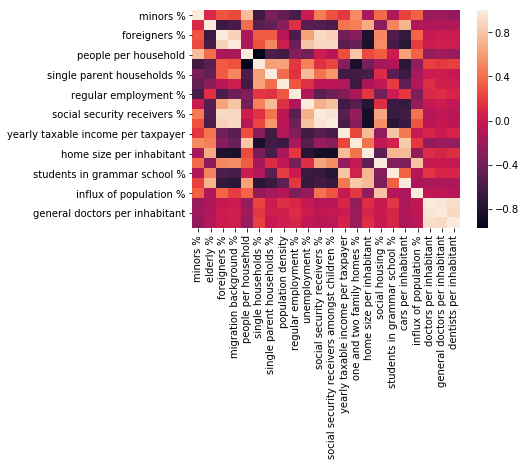

In [232]:
sns.heatmap(df_data.corr())

Some features such as unemployment and reliance on social security are highly correclated.

## Clustering of neighbourhoods by demogrpahics

In [233]:
#Normalize data
df_data_cluster = df_data.drop('neighbourhood', 1)
X = df_data_cluster.values[:,1:]
#X = np.nan_to_num(X)
df_data_cluster = StandardScaler().fit_transform(X)

In [234]:
# k means
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_data_cluster)
kmeans.labels_[0:22] 

array([5, 0, 1, 1, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 0, 1, 1, 1, 1, 0, 2], dtype=int32)

In [235]:
df_data.insert(0, 'cluster', kmeans.labels_)

## Add location data to demographics data set

neighbourhood titles are not completely the same

In [236]:
# find differences
print(set(df.neighbourhood) - set(df_data.neighbourhood))
print(set(df_data.neighbourhood) - set(df.neighbourhood))

{'Kleiner Grasbrook', 'Steinwerder', 'Finkenwerder', 'Waltershof', 'Moorburg', 'Neuland', 'Gut Moor', 'Neuwerk', 'Altenwerder'}
{'Moorburg und Altenwerder', 'Neuland und Gut Moor', 'Waltershof und Finkenwerder', 'Kleiner Grasbrook und Steinwerder'}


In [237]:
# clean differences
df=df[df.neighbourhood != "Neuwerk"]

df["neighbourhood"]= df["neighbourhood"].replace("Kleiner Grasbrook", "Kleiner Grasbrook und Steinwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Steinwerder", "Kleiner Grasbrook und Steinwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Finkenwerder", "Waltershof und Finkenwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Waltershof", "Waltershof und Finkenwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Moorburg", "Moorburg und Altenwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Altenwerder", "Moorburg und Altenwerder") 
df["neighbourhood"]= df["neighbourhood"].replace("Neuland", "Neuland und Gut Moor") 
df["neighbourhood"]= df["neighbourhood"].replace("Gut Moor", "Neuland und Gut Moor") 

df.groupby(["neighbourhood"], as_index=False).mean()
df.head()

,neighbourhood,borough,latitude,longitude
0,Hamburg-Altstadt,Hamburg-Mitte,53.550000,10.000000
1,HafenCity,Hamburg-Mitte,53.541111,10.000278
2,Neustadt,Hamburg-Mitte,53.551944,9.985556
3,St. Pauli,Hamburg-Mitte,53.556944,9.963889
4,St. Georg,Hamburg-Mitte,53.555000,10.012222


In [238]:
# Add location data
df_data_loc=pd.merge(df, df_data, on='neighbourhood')
df_data_loc.head()

,neighbourhood,borough,latitude,longitude,cluster,minors %,elderly %,foreigners %,migration background %,people per household,...,yearly taxable income per taxpayer,one and two family homes %,home size per inhabitant,social housing %,students in grammar school %,cars per inhabitant,influx of population %,doctors per inhabitant,general doctors per inhabitant,dentists per inhabitant
0,Hamburg-Altstadt,Hamburg-Mitte,53.550000,10.000000,5,12.017354,11.106291,21.952278,42.912874,1.592838,...,31336,1.263001,42.855531,14.041605,40.983607,0.272885,0.043384,0.069848,0.020824,0.019523
1,HafenCity,Hamburg-Mitte,53.541111,10.000278,0,20.843672,9.181141,32.202923,47.262724,2.115759,...,93206,0.405954,37.814723,0.541272,46.376812,0.264682,6.561897,0.003584,0.001379,0.001930
2,Neustadt,Hamburg-Mitte,53.551944,9.985556,1,11.447441,14.435097,20.284614,36.644696,1.498001,...,34521,0.895482,37.064235,18.176958,48.250000,0.246167,0.047174,0.013602,0.001415,0.005975
3,St. Pauli,Hamburg-Mitte,53.556944,9.963889,1,13.292743,9.555131,21.687925,36.801311,1.532348,...,27977,1.354058,35.629883,14.646262,39.242054,0.194214,0.488867,0.001733,0.000489,0.000667
4,St. Georg,Hamburg-Mitte,53.555000,10.012222,1,10.022614,12.636816,23.084577,38.608853,1.515055,...,44121,0.919389,39.168521,11.229683,54.180602,0.208051,2.125735,0.009588,0.003256,0.001357


### Analysis of clusters

#### Cluster with neighbourhoods further away from the center, mainly families.

In [246]:
df_data[df_data.cluster == 0].neighbourhood

1                       HafenCity
15    Waltershof und Finkenwerder
20                     Bahrenfeld
23                          Lurup
24                         Osdorf
28                       Sülldorf
34                       Lokstedt
36                      Schnelsen
37                     Eidelstedt
38                     Stellingen
41                   Groß Borstel
42                     Alsterdorf
49                       Ohlsdorf
50                    Fuhlsbüttel
51                     Langenhorn
54                     Marienthal
56                       Tonndorf
57                  Farmsen-Berne
58                       Bramfeld
63                  Hummelsbüttel
69                      Rahlstedt
70                      Lohbrügge
71                      Bergedorf
83                   Neuallermöhe
85           Neuland und Gut Moor
86                       Wilstorf
89                       Sinstorf
91                      Eißendorf
92                       Heimfeld
94            

#### Cluster with trendy neighbourhoods in central Hamburg

In [247]:
df_data[df_data.cluster == 1].neighbourhood

2            Neustadt
3           St. Pauli
4           St. Georg
6           Borgfelde
7                Hamm
16    Altona-Altstadt
17       Sternschanze
18        Altona-Nord
19           Ottensen
30         Eimsbüttel
31         Rotherbaum
33      Hoheluft-West
39       Hoheluft-Ost
40          Eppendorf
43         Winterhude
44         Uhlenhorst
45         Hohenfelde
46        Barmbek-Süd
48       Barmbek-Nord
52             Eilbek
53           Wandsbek
Name: neighbourhood, dtype: object

#### This cluster with  high income neighboorhoods not too close to the center.

In [248]:
df_data[df_data.cluster == 2].neighbourhood

21           Groß Flottbek
22             Othmarschen
25             Nienstedten
26              Blankenese
29                  Rissen
32            Harvestehude
60          Wellingsbüttel
61                   Sasel
62            Poppenbüttel
64    Lemsahl-Mellingstedt
65              Duvenstedt
66       Wohldorf-Ohlstedt
68               Volksdorf
Name: neighbourhood, dtype: object

#### Cluster with middle class neighboorhoods farther away from the center.

In [249]:
df_data[df_data.cluster == 3].neighbourhood

27                   Iserbrook
35                    Niendorf
67                   Bergstedt
72                    Curslack
73                  Altengamme
74                  Neuengamme
75                 Kirchwerder
76                Ochsenwerder
77                   Reitbrook
78                   Allermöhe
80                   Moorfleet
81                   Tatenberg
82                  Spadenland
87                   Rönneburg
88                   Langenbek
90                   Marmstorf
93    Moorburg und Altenwerder
96                     Francop
Name: neighbourhood, dtype: object

#### This cluster only contains one neighbourhood. This is one of the poorest and most problematic neighbourhoods.

In [250]:
df_data[df_data.cluster == 4].neighbourhood

79    Billwerder
Name: neighbourhood, dtype: object

#### This cluster contains only one neighbourhood. This is the old part of central Hamburg where few people live.

In [251]:
df_data[df_data.cluster == 5].neighbourhood

0    Hamburg-Altstadt
Name: neighbourhood, dtype: object

#### The last cluster consists of poorer neighbourhoods

In [252]:
df_data[df_data.cluster == 6].neighbourhood

5                           Hammerbrook
8                                  Horn
9                             Billstedt
10                            Billbrook
11                       Rothenburgsort
12                               Veddel
13                         Wilhelmsburg
14    Kleiner Grasbrook und Steinwerder
47                             Dulsberg
55                              Jenfeld
59                           Steilshoop
84                              Harburg
Name: neighbourhood, dtype: object

## Visualization

 ### Hamburg Map

In [253]:
# Get longitute and latitude of hamburg
address = 'Hamburg'
geolocator = Nominatim(user_agent="data_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hamburg are 53.550341, 10.000654.


In [254]:
# create map of Hamburg
map_ham = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers for neighbourhoods
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(df_data_loc['latitude'],df_data_loc['longitude'], df_data_loc['neighbourhood'],df_data_loc['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1], 
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ham)
map_ham

### Foursquare data

In [57]:
#@hidden cell
#Foursquare
CLIENT_ID = 'QBEGFENKFBACTE20G0IPX505NAOKKST1CTTDVZSYCBWLDQNU' #'HSBYPUED5PK4C33NNPPMJOKDNZUHIFLK5NZKYX5ALI4DX0TN' # your Foursquare ID
CLIENT_SECRET = 'IWXNELLAFHKKNK2FLAL3MXI41USPBFLRLHRU4B32FXJRJGFK' #'UMKEUH4CLQVDUF3HK22NZZJOOZ12ZM2PUFXCLIGK3SH4UCBK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius =10000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [293]:
# Get venues from foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
               
        
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighbourhood', 
                  'latitude', 
                  'longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [294]:
ham_venues = getNearbyVenues(names=df['neighbourhood'], latitudes=df['latitude'], longitudes=df['longitude'])
ham_venues.head()

,neighbourhood,latitude,longitude,venue,venue latitude,venue longitude,venue category
0,Hamburg-Altstadt,53.55,10.0,Shiso Burger,53.550648,10.001897,Burger Joint
1,Hamburg-Altstadt,53.55,10.0,GOOT - Finest Cuts,53.548509,10.000675,Comfort Food Restaurant
2,Hamburg-Altstadt,53.55,10.0,Passage Kino,53.550708,9.998299,Indie Movie Theater
3,Hamburg-Altstadt,53.55,10.0,Die Rösterei,53.549879,10.001518,Coffee Shop
4,Hamburg-Altstadt,53.55,10.0,Park Hyatt Hamburg,53.550977,10.003158,Hotel


In [295]:
ham_restaurants_columns= ham_venues.columns[ham_venues.columns.str.contains('Restaurant')]
ham_restaurants=ham_venues[ham_restaurants_columns]
ham_restaurants=ham_venues[ham_venues["venue category"].str.contains('Restaurant')]
ham_restaurants=ham_restaurants[ham_restaurants["venue category"] != "Restaurant"] # drop restaurants without category


# one hot encoding
ham_onehot = pd.get_dummies(ham_restaurants[['venue category']], prefix="", prefix_sep="")
ham_onehot['neighbourhood'] = ham_restaurants['neighbourhood'] 

ham_grouped = ham_onehot.groupby('neighbourhood').mean().reset_index()
ham_grouped.head()

,neighbourhood,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bavarian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,...,Schnitzel Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Swabian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Altona-Nord,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bahrenfeld,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Barmbek-Nord,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Barmbek-Süd,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bergedorf,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [296]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [297]:
# Show top venues pr neighbourhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['neighbourhood'] = ham_grouped['neighbourhood']

for ind in np.arange(ham_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ham_grouped.iloc[ind, :], num_top_venues)

### K means clustering

In [298]:
# k means
kclusters = 7
ham_grouped_clustering = ham_grouped.drop('neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ham_grouped_clustering)
kmeans.labels_[0:10] 

array([4, 2, 4, 2, 2, 2, 2, 2, 4, 1], dtype=int32)

In [299]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'cluster', kmeans.labels_)

### Restaurant preference clusters

#### Indian and Vietnamese Food

In [300]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 0]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
15,0,Fuhlsbüttel,Indian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Halal Restaurant
33,0,Ohlsdorf,Indian Restaurant,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant


#### Greek and Vietnamese Food

In [301]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 1]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
9,1,Dulsberg,Greek Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant
19,1,Hamm,Greek Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
41,1,Rönneburg,Greek Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
48,1,Wandsbek,Greek Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant


#### Italian Food and Fast Food

In [302]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 2]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
1,2,Bahrenfeld,Italian Restaurant,Asian Restaurant,Indian Restaurant,Vietnamese Restaurant,Falafel Restaurant
3,2,Barmbek-Süd,Doner Restaurant,Falafel Restaurant,German Restaurant,Italian Restaurant,Indian Restaurant
4,2,Bergedorf,Sushi Restaurant,Schnitzel Restaurant,Vietnamese Restaurant,Doner Restaurant,Indian Restaurant
5,2,Billstedt,Fast Food Restaurant,Turkish Restaurant,Mediterranean Restaurant,German Restaurant,Seafood Restaurant
6,2,Blankenese,Italian Restaurant,Tapas Restaurant,Doner Restaurant,Indian Restaurant,Halal Restaurant
7,2,Bramfeld,Italian Restaurant,Asian Restaurant,Sushi Restaurant,Falafel Restaurant,Indian Restaurant
10,2,Duvenstedt,Modern European Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Halal Restaurant
11,2,Eilbek,Dim Sum Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
12,2,Eimsbüttel,Italian Restaurant,Korean Restaurant,Asian Restaurant,Spanish Restaurant,Middle Eastern Restaurant
17,2,HafenCity,Asian Restaurant,Tapas Restaurant,Bavarian Restaurant,Mediterranean Restaurant,German Restaurant


#### Italian and Vietnamese Food

In [303]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 3]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
22,3,Harvestehude,Italian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Halal Restaurant
28,3,Lokstedt,Italian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Halal Restaurant
31,3,Nienstedten,Italian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Halal Restaurant
38,3,Rissen,Italian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Halal Restaurant
47,3,Uhlenhorst,Italian Restaurant,Asian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant


#### German and Vietnamese Food

In [304]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 4]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,4,Altona-Nord,German Restaurant,French Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant
2,4,Barmbek-Nord,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
8,4,Cranz,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
13,4,Eppendorf,Argentinian Restaurant,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant
16,4,Groß Flottbek,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
25,4,Hummelsbüttel,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
26,4,Jenfeld,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
32,4,Ochsenwerder,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
35,4,Othmarschen,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant


#### Asian Food

In [305]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 5]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
29,5,Moorfleet,Asian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
42,5,Sasel,Asian Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant


#### Fast Food


In [306]:
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted.cluster == 6]

,cluster,neighbourhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
14,6,Farmsen-Berne,Fast Food Restaurant,German Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant
21,6,Harburg,Fast Food Restaurant,Thai Restaurant,Seafood Restaurant,Vietnamese Restaurant,Doner Restaurant
27,6,Langenhorn,Fast Food Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant
43,6,Sinstorf,Fast Food Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant


Is there a link between clusters found based on demographics and clusters found by restaurant preferences?

In [346]:
df_merged=pd.merge(df_data, neighbourhoods_venues_sorted, on='neighbourhood')
df_merged=df_merged[["neighbourhood","cluster_x","cluster_y"]]

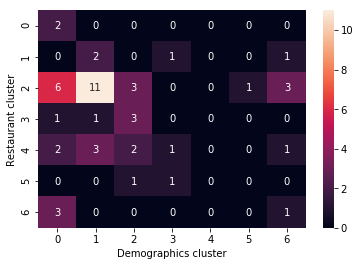

In [340]:
cm = confusion_matrix(df_merged["cluster_y"], df_merged["cluster_x"]) 
plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel('Demographics cluster')
plt.ylabel('Restaurant cluster')
plt.show()

In [349]:
# Neighbouhoods in central Hamburg sharing a preference for Italian Food and Fast Food
dd=df_merged[df_merged.cluster_x == 1]
dd[dd.cluster_y == 2]

,neighbourhood,cluster_x,cluster_y
2,Neustadt,1,2
3,St. Pauli,1,2
4,St. Georg,1,2
9,Sternschanze,1,2
18,Eimsbüttel,1,2
19,Rotherbaum,1,2
21,Hoheluft-West,1,2
23,Hoheluft-Ost,1,2
25,Winterhude,1,2
27,Barmbek-Süd,1,2


### Recommendation
Given the similarities to Eimsbüttel both in terms of demographics and restaurant preferences we recommend to open the new branch of "Fast Pizza" in Hoheluft of Winterhude.